In [1]:
from pathlib import Path
import os
import copy
from PIL import Image

from typing import Optional, Any

from scipy.io import loadmat
from IPython.display import display

import torch
from torch._tensor import Tensor
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.dataset import Subset
from torchvision import datasets, transforms

BASE_DIR = Path(os.getcwd()).parent

# use cuda gpu if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
data_dir = BASE_DIR/"data"
print(data_dir)

/home/zelluzy/Desktop/code/flowers/data


In [3]:
# get data to calculate mean + std for normalization and to get pixel size
temp_data = datasets.Flowers102(
    root=data_dir,
    download=True
)

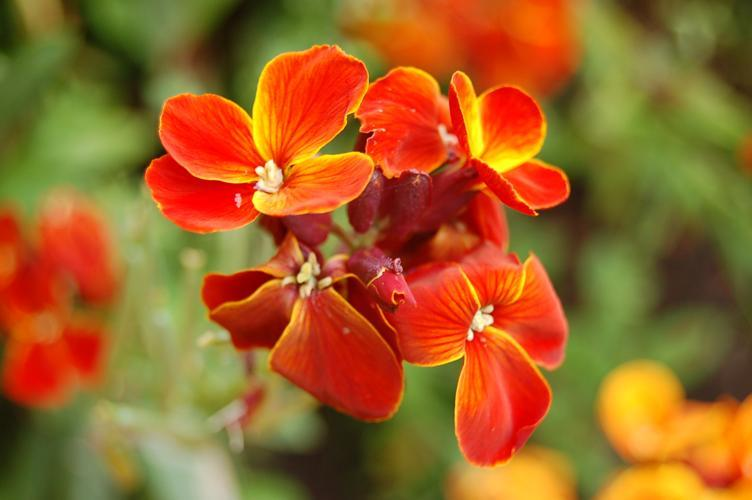

img.size=(752, 500), label=45, category: 'wallflower'


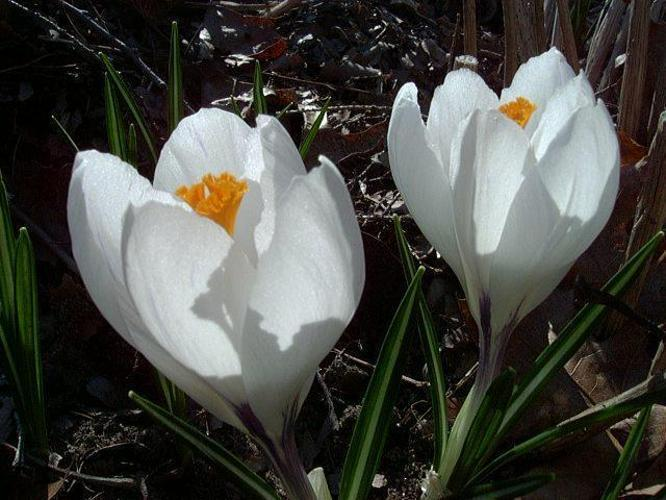

img.size=(666, 500), label=66, category: 'spring crocus'


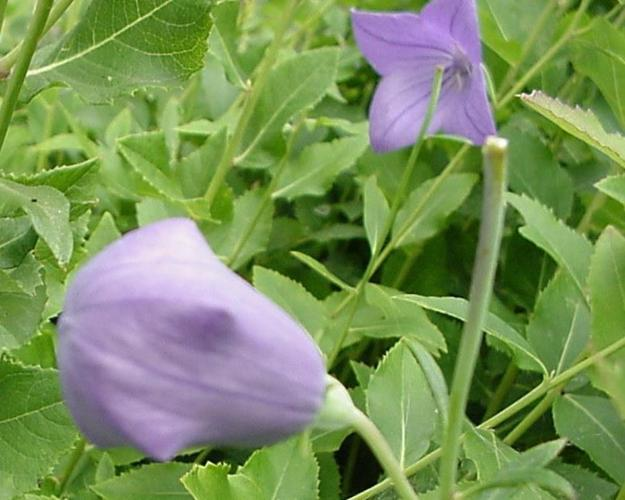

img.size=(625, 500), label=18, category: 'balloon flower'


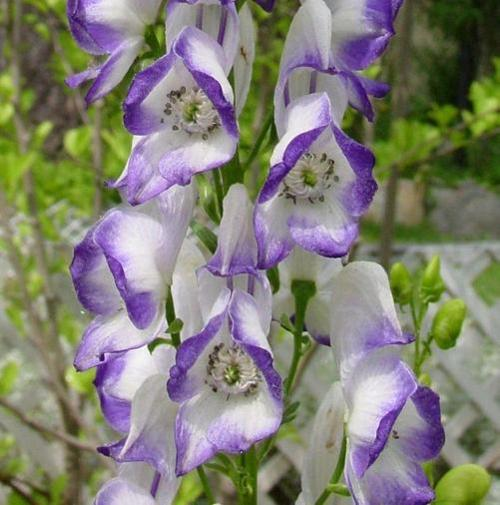

img.size=(500, 505), label=8, category: 'monkshood'


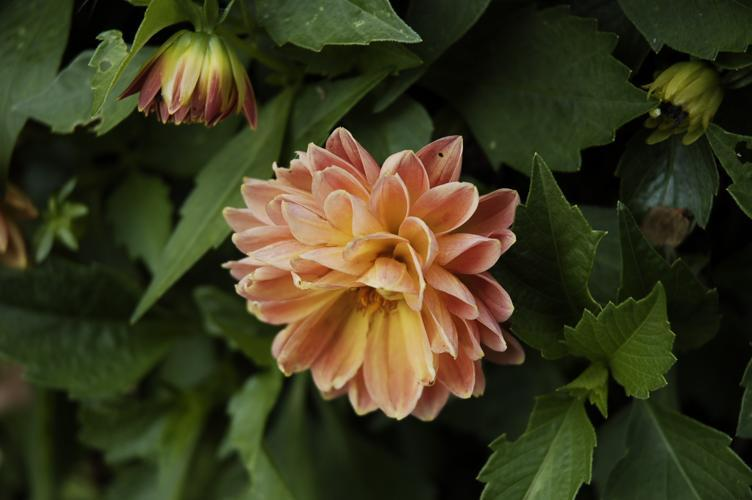

img.size=(752, 500), label=59, category: 'pink-yellow dahlia?'


In [4]:
labels_txt = data_dir/"Oxford-102_Flower_dataset_labels.txt"
with open(labels_txt) as f:
    labels = f.read().splitlines()
    
for i in torch.randint(low=0, high=len(temp_data), size=(5,)):
    img, label = temp_data[i] # type: ignore
    cat = labels[label]
    display(img)
    print(f"{img.size=}, {label=}, category:{cat}")

In [5]:
# create custom flower dataset
class FlowerDataset(Dataset):
    def __init__(self, root_dir: Path, transform: Optional[transforms.Compose]=None):
        self.root_dir = root_dir
        self.classes_path = root_dir/"Oxford-102_Flower_dataset_labels.txt"
        self.flowers_path = root_dir/"flowers-102"
        
        self.transform = transform
        self.image_dir = self.flowers_path/"jpg"
        self.labels = self.load_labels()
        self.classes = self.get_classes()
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx) -> tuple[Any, int]:
        if torch.is_tensor(idx):
            idx = idx.item()
        image = self.get_image(idx)
        
        #apply optional transform
        if self.transform is not None:
            image = self.transform(image)
        
        label = self.labels[idx]
        
        return image, label
    
    def load_labels(self):
        self.labels_mat = loadmat(self.flowers_path/"imagelabels.mat")
        # subtract one from labels to make them 0 indexed
        labels = self.labels_mat["labels"][0] - 1
        return labels
    
    def get_image(self, idx):
        # image index in name has 5 digits and is 1 indexed 
        # (eg. image_00001.jpg)
        img_name = f"image_{idx + 1:05d}.jpg"
        img_path = os.path.join(self.image_dir, img_name)
        with Image.open(img_path) as img:
            image = img.convert("RGB")
        return image

    def get_classes(self):
        classes_path = self.root_dir/"Oxford-102_Flower_dataset_labels.txt"
        with open(classes_path) as f:
            classes = f.read().splitlines()
        return classes
            

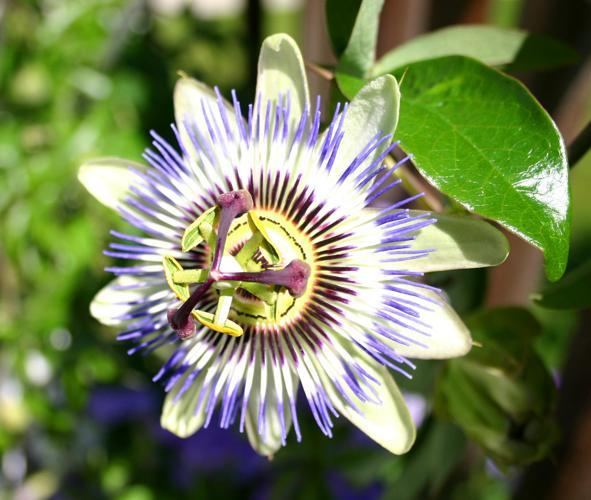

In [6]:
# test Custom Dataset
dataset = FlowerDataset(data_dir)
assert len(dataset) == 8189
display(dataset[0][0])


In [7]:
uniformize_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor()
    # I will normalize later after i calculate mean and std
])

In [8]:
def get_mean_std() -> tuple[Tensor, Tensor]:
    """get mean and std for flower dataset for normalization

    Returns:
        tuple: mean, std
    """
    temp_data = datasets.Flowers102(
        root=data_dir,
        download=True,
        transform=uniformize_transform
    )
    # switch to updated DataLoader
    temp_loader = DataLoader(temp_data, batch_size=1024)
    # concatenate images along dim 0
    
    all_images = torch.cat([imgs for imgs, _ in temp_loader], dim=0)
    # compute on all dims except dim 1 to get values for RGB
    mean = all_images.mean(dim=[0,2,3])
    std = all_images.std(dim=[0,2,3])
    
    # remove temp data from memory
    del temp_data
    del temp_loader
    del all_images
    
    return mean, std

In [9]:
mean, std = get_mean_std()
print(f"flowers {mean=}, {std=}")

flowers mean=tensor([0.4727, 0.3996, 0.3193]), std=tensor([0.2965, 0.2471, 0.2812])


In [10]:
# augmentation for training
train_transform = transforms.Compose([
    uniformize_transform,
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.Normalize(mean=mean, std=std)
])

# val and test; no augmentation
val_transform = transforms.Compose([
    uniformize_transform,
    transforms.Normalize(mean=mean, std=std)
])

In [11]:
class SubsetWithTransform(Dataset):
    def __init__(self, subset: Subset, transform: Optional[transforms.Compose] = None) -> None:
        super().__init__()
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, index) -> Any:
        image, label = self.subset[index]  # type: ignore
        if self.transform is not None:
            image = self.transform(image)
        return image, label


In [12]:
# split dataset
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [0.7, 0.15, 0.15]
)
print(f"{train_dataset=}, {len(val_dataset)=}, {len(test_dataset)=}")

train_dataset=<torch.utils.data.dataset.Subset object at 0x7f15a70d8ad0>, len(val_dataset)=1228, len(test_dataset)=1228


In [13]:
# apply transforms
train_dataset = SubsetWithTransform(train_dataset, train_transform)
val_dataset = SubsetWithTransform(val_dataset, val_transform)
test_dataset = SubsetWithTransform(test_dataset, val_transform)

In [14]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [15]:
class CNNBlock(nn.Module):
    """a simple CNN Block with 4 layers:
    conv2d: for learning filters
    batchnorm2d: to stabilize and accelerate training
    relu: to make non-linear
    maxpool2d: to downsample the feature map

    Args:
        nn (_type_): _description_
    """
    def __init__(self,in_channels: int, out_channels: int, kernel_size: int=3,
                 padding:int=1, *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    
    def forward(self, x) -> Tensor:
        return self.block(x)


In [16]:
test_cnn_block = CNNBlock(in_channels=3, out_channels=16)
print(test_cnn_block)

test_input = torch.randn(1, 3, 32, 32)
print(f"{test_input.shape=}")
test_output = test_cnn_block(test_input)
print(f"{test_output.shape=}")

CNNBlock(
  (block): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
test_input.shape=torch.Size([1, 3, 32, 32])
test_output.shape=torch.Size([1, 16, 16, 16])


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, single_img_shape: torch.Size, num_classes: int, *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)
        
        self.features = nn.Sequential(
            CNNBlock(in_channels=single_img_shape[0], out_channels=32),
            CNNBlock(in_channels=32, out_channels=64),
            CNNBlock(in_channels=64, out_channels=128),
            CNNBlock(in_channels=128, out_channels=256),
            CNNBlock(in_channels=256, out_channels=512),
            CNNBlock(in_channels=512, out_channels=1024)
        )
        
        # height and width are reduced to half 6 times
        # use floor division because that is what pytorch pooling uses 
        # to prevent mismatched shapes if image cant be divided by 2**6
        reduced_h = single_img_shape[1] // 2**6
        reduced_w = single_img_shape[2] // 2**6
        
        # input to first fully connected layer
        self.fcl_in = reduced_h * reduced_w * 1024
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.fcl_in, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.Linear(512, num_classes),
        )


In [18]:
# verify cnn
dummy_input = torch.randn(64, 3, 244, 244)
verify_cnn = SimpleCNN(single_img_shape=dummy_input.shape[1:], num_classes=10)
print("Model Structure:\n")
print(verify_cnn)

print(f"{dummy_input.shape=}")

output = verify_cnn(dummy_input)
print(f"{output.shape=}")

Model Structure:

SimpleCNN(
  (features): Sequential(
    (0): CNNBlock(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): CNNBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): CNNBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(ker

In [19]:
def train_epoch(
    model: nn.Module, 
    train_loader: DataLoader, 
    loss_function: nn.CrossEntropyLoss, 
    optimizer:optim.Adam,
    device: torch.device
):
    model.train()
    running_loss = 0.
    
    for images, labels in train_loader:
        # move data to device
        images, labels = images.to(device), labels.to(device)
        # reset grads
        optimizer.zero_grad()
        # compute predictions
        outputs = model(images)
        # compute loss
        loss = loss_function(outputs, labels)
        # compute grads
        loss.backward()
        # update model weights
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
    epoch_loss = running_loss / len(train_loader)
    return epoch_loss

In [20]:
def val_epoch(
    model: nn.Module, 
    val_loader: DataLoader, 
    loss_function: nn.CrossEntropyLoss, 
    device: torch.device
):
    model.eval()
    running_val_loss = 0.
    correct = 0
    total = 0
    
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        val_loss = loss_function(outputs, labels)
        
        running_val_loss += val_loss.item() * images.size(0)
        
        predicted  = outputs.argmax(dim=1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_accuracy = 100. * correct / total
    
    return epoch_val_loss, epoch_accuracy

In [21]:
def train(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    loss_function: nn.CrossEntropyLoss,
    optimizer: optim.Adam,
    # use the actual scheduler class (or a generic base) instead of the module
    scheduler: optim.lr_scheduler.ReduceLROnPlateau,
    num_epochs: int,
    device: torch.device
):
    # Move the model to the specified device (CPU or GPU)
    model.to(device)
    
    # Initialize variables to track the best performing model
    best_val_accuracy = 0.0
    best_model_state = None
    best_epoch = 0
    
    # Initialize lists to store training and validation metrics
    train_losses, val_losses, val_accuracies = [], [], []
    
    print("--- Training Started ---")
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        # Perform one epoch of training
        epoch_loss = train_epoch(model, train_loader, loss_function, optimizer, device)
        train_losses.append(epoch_loss)
        
        # Perform one epoch of validation
        epoch_val_loss, epoch_accuracy = val_epoch(model, val_loader, loss_function, device)
        scheduler.step(epoch_accuracy)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_accuracy)
        
        # Print the metrics for the current epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_accuracy:.2f}%")
        
        # Check if the current model is the best one so far
        if epoch_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_accuracy
            best_epoch = epoch + 1
            # Save the state of the best model in memory
            best_model_state = copy.deepcopy(model.state_dict())
            
    print("--- Finished Training ---")
    
    # Load the best model weights before returning
    if best_model_state:
        print(f"\n--- Returning best model with {best_val_accuracy:.2f}% validation accuracy, achieved at epoch {best_epoch} ---")
        model.load_state_dict(best_model_state)
    
    # Consolidate all metrics into a single list
    metrics = [train_losses, val_losses, val_accuracies]
    
    # Return the trained model and the collected metrics
    return model, metrics

In [22]:
print(len(dataset.classes))
print(train_dataset[0][0].shape)

102
torch.Size([3, 224, 224])


In [23]:
num_classes = len(dataset.classes)
single_img_shape = train_dataset[0][0].shape

model = SimpleCNN(single_img_shape=single_img_shape, num_classes=num_classes)

loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0005)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

num_epochs = 50


In [24]:
model, metrics = train(model, train_loader, val_loader, loss_function, optimizer,scheduler, num_epochs, device)

--- Training Started ---
Epoch [1/50], Train Loss: 467.0809, Val Loss: 272.8893, Val Accuracy: 4.64%
Epoch [2/50], Train Loss: 284.2999, Val Loss: 264.9432, Val Accuracy: 4.07%
Epoch [3/50], Train Loss: 279.1836, Val Loss: 255.0822, Val Accuracy: 7.25%
Epoch [4/50], Train Loss: 276.1459, Val Loss: 249.5744, Val Accuracy: 8.71%
Epoch [5/50], Train Loss: 273.1682, Val Loss: 248.7237, Val Accuracy: 10.10%
Epoch [6/50], Train Loss: 270.9030, Val Loss: 247.3548, Val Accuracy: 9.28%
Epoch [7/50], Train Loss: 270.3837, Val Loss: 245.0807, Val Accuracy: 10.10%
Epoch [8/50], Train Loss: 268.0748, Val Loss: 241.9497, Val Accuracy: 10.10%
Epoch [9/50], Train Loss: 267.1319, Val Loss: 244.6953, Val Accuracy: 6.19%
Epoch [10/50], Train Loss: 266.1188, Val Loss: 238.5666, Val Accuracy: 9.69%
Epoch [11/50], Train Loss: 266.1205, Val Loss: 238.8023, Val Accuracy: 9.04%
Epoch [12/50], Train Loss: 261.2705, Val Loss: 231.6810, Val Accuracy: 10.18%
Epoch [13/50], Train Loss: 254.7705, Val Loss: 224.8191,

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "flower_model_weights.pth")

In [ ]:
model.eval()
model(test_loader)